<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/CLV_CUSTOMER_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 7.5 MB/s 


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import feature_column as tfc
from six import iteritems

In [3]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [4]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01 07:45:00,1.25,13085,United Kingdom


In [5]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['date'] = data['InvoiceDate'].dt.date
data['Sales'] = data['Price']*data['Quantity']

In [6]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,date,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01 07:45:00,6.95,13085,United Kingdom,2019-12-01,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom,2019-12-01,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom,2019-12-01,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01 07:45:00,2.10,13085,United Kingdom,2019-12-01,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01 07:45:00,1.25,13085,United Kingdom,2019-12-01,30.0


In [7]:
threshold_date = dt.date(2021,9,9)
predict_date = dt.date(2021,12,9)

In [8]:
latest_order = data.groupby('CustomerID').agg({'date':'max'}).reset_index()
latest_order.columns = ['CustomerID','latestorder']

t1 = data.groupby(['CustomerID','date']).agg({'Sales':'sum','Quantity':'sum'}).reset_index()
t1 = pd.merge(t1,latest_order,on='CustomerID',how='left')

In [9]:
t2 = data[data['date']<threshold_date]
t2 = t2.groupby(['CustomerID','date']).agg({'Sales':'sum'}).reset_index()
t2['Sales'] = t2['Sales'].round(2)
t2['flag'] = np.where(t2['Sales']>0,1,0)
t2 = t2.groupby('CustomerID').agg({'flag':'sum'}).reset_index()
t2 = t2[t2['flag']>1]

In [10]:
t3 = pd.merge(t1,t2['CustomerID'],on='CustomerID',how='inner')
t3['datediff'] =  (predict_date - t3['latestorder']).dt.days
t3 = t3[(t3['datediff']<=90) & 
        (((t3['Quantity']>0) & (t3['Sales']>0)) | 
         ((t3['Quantity']<0) & (t3['Sales']<0)))]        
t3 = t3[['CustomerID','date','Sales','Quantity']]
t3.columns = ['customer_id','order_date','order_value','order_qty_articles']

In [11]:
first_order = t3.groupby('customer_id').agg({'order_date':'min'}).reset_index()
first_order.columns = ['customer_id','order_date_min']

In [12]:
t4 = pd.merge(t3,first_order,on='customer_id',how='inner')
t4['order_value_btyd'] = np.where(t4['order_date_min']==t4['order_date'],0,t4['order_value'])
t4 = t4[t4['order_date']<=threshold_date]

In [13]:
def aggregations(x):
    d = {}
    d['monetary_dnn'] = x['order_value'].sum()
    d['cnt_orders'] = x['order_date'].nunique()
    d['monetary_btyd'] = np.where(d['cnt_orders']==1,0,x['order_value_btyd'].sum()/(d['cnt_orders']-1))
    d['recency'] = (x['order_date'].max()-x['order_date'].min()).days
    d['T'] = (threshold_date-x['order_date'].min()).days
    d['avg_basket_size'] = x['order_qty_articles'].mean()
    d['avg_basket_value'] = x['order_value'].mean()
    d['cnt_returns'] = np.where(x['order_value']<0,1,0).sum()
    return pd.Series(d, index=['monetary_dnn','cnt_orders','monetary_btyd','recency','T','avg_basket_size',
                               'avg_basket_value','cnt_returns'])

t5 = t4.groupby('customer_id').apply(aggregations).reset_index()

In [14]:
target = t3.groupby('customer_id').agg({'order_value':'sum'}).reset_index()
target.columns = ['customer_id','target_monetary']
target['target_monetary'] = target['target_monetary'].round(2)

In [15]:
t6 = pd.merge(t5,target,on='customer_id',how='inner')
t6['frequency_btyd'] = t6['cnt_orders']-1
t6['time_between'] = (t6['recency']/t6['cnt_orders']).round(2)
t6['avg_basket_value'] = t6['avg_basket_value'].round(2)
t6['avg_basket_size'] = t6['avg_basket_size'].round(2)
t6['frequency_dnn'] = t6['cnt_orders']
t6['has_returned'] = np.where(t6['cnt_returns']>0,1,0)
t6['frequency_btyd_clipped'] = np.where(t6['cnt_orders']>600,600,t6['cnt_orders'])
t6['monetary_btyd_clipped'] = np.where(t6['monetary_btyd']>100000,100000,t6['monetary_btyd'])
t6['target_monetary_clipped'] = np.where(t6['target_monetary']>100000,100000,t6['target_monetary'])
t6 = t6[['customer_id','monetary_dnn','monetary_btyd','frequency_dnn','frequency_btyd','recency','T',
         'time_between','avg_basket_value','avg_basket_size','cnt_returns','has_returned',
         'frequency_btyd_clipped','monetary_btyd_clipped','target_monetary_clipped','target_monetary']]
t6 = t6[(t6['monetary_dnn']>0)&(t6['monetary_btyd']>0)]

t6

,customer_id,monetary_dnn,monetary_btyd,frequency_dnn,frequency_btyd,recency,T,time_between,avg_basket_value,avg_basket_size,cnt_returns,has_returned,frequency_btyd_clipped,monetary_btyd_clipped,target_monetary_clipped,target_monetary
0,12347,3402.39,558.1719999999999,6,5,275,313,45.83,567.07,349.83,0,0,6,558.1719999999999,4921.53,4921.53
1,12348,1709.40,495.74666666666667,4,3,190,347,47.50,427.35,624.25,0,0,4,495.74666666666667,2019.40,2019.40
2,12349,2671.14,801.31,3,2,182,498,60.67,890.38,331.00,0,0,3,801.31,4428.69,4428.69
3,12352,1905.61,352.37199999999996,6,5,130,301,21.67,317.60,73.67,0,0,6,352.37199999999996,2849.84,2849.84
4,12356,6313.38,1350.735,5,4,179,333,35.80,1262.68,682.20,0,0,5,1350.735,6371.73,6371.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,18273,306.00,76.5,3,2,495,499,165.00,102.00,40.00,0,0,3,76.5,357.00,357.00
1945,18276,1320.66,275.65250000000003,5,4,338,639,67.60,264.13,212.00,0,0,5,275.65250000000003,1656.52,1656.52
1946,18277,1069.67,366.265,3,2,97,403,32.33,356.56,127.00,0,0,3,366.265,1180.05,1180.05
1947,18283,1706.20,123.7923076923077,14,13,564,568,40.29,121.87,74.36,0,0,14,123.7923076923077,2664.90,2664.90


In [16]:
first_order = t3.groupby('customer_id').agg({'order_date':'min'}).reset_index()
first_order.columns = ['customer_id','order_date_min']

count    1949.000000
mean        8.464341
std        13.052979
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max       205.000000
Name: frequency_btyd, dtype: float64
0.15033350436121087


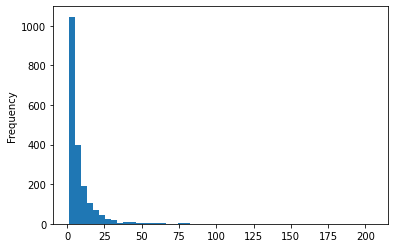

In [17]:
t6['frequency_btyd'].plot(kind='hist', bins=50)
print(t6['frequency_btyd'].describe())
print(sum(t6['frequency_btyd'] == 1)/float(len(t6)))

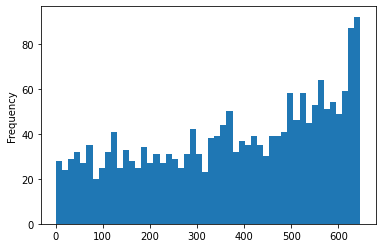

In [18]:
t6['recency'].plot(kind='hist', bins=50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


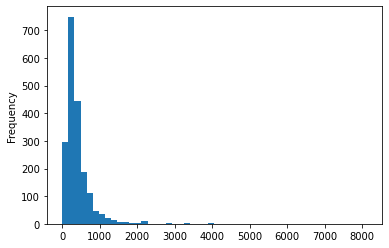

In [19]:
t6['monetary_btyd']= t6['monetary_btyd'].apply(np.int)
t6['monetary_btyd'].plot(kind='hist', bins=50)

Probabilistic Model

In [20]:
from datetime import datetime
from lifetimes import BetaGeoFitter, ParetoNBDFitter, GammaGammaFitter
import math
import numpy as np
import os
import pandas as pd
import tensorflow as tf

PENALIZER_COEF = 0.01
DISCOUNT_RATE = 0.01

In [21]:
summary = t6[['customer_id', 'frequency_btyd', 'recency', 'T', 'monetary_btyd']]
summary.columns = ['customer_id', 'frequency', 'recency', 'T', 'monetary_value']
summary = summary.set_index('customer_id')

actual_df = t6[['customer_id', 'frequency_btyd', 'monetary_dnn', 'target_monetary']]
actual_df.columns = ['customer_id', 'train_frequency', 'train_monetary', 'act_target_monetary']

In [22]:
def paretonbd_model(summary):
    paretof = ParetoNBDFitter(penalizer_coef=PENALIZER_COEF)
    paretof.fit(summary['frequency'], summary['recency'], summary['T'])
    return paretof

In [23]:
def predict_value(summary, actual_df, fitter, ggf, time_days, time_months):
    ltv = pd.DataFrame(data=np.zeros([actual_df.shape[0], 6]),
                       columns=['customer_id',
                              'actual_total',
                              'predicted_num_purchases',
                              'predicted_value',
                              'predicted_total',
                              'error'], dtype=np.float32)

    predicted_purchases = fitter.predict(time_days,
                                           summary['frequency'],
                                           summary['recency'],
                                           summary['T'])

    predicted_CLV = ggf.customer_lifetime_value(fitter,
                                                summary['frequency'],
                                                summary['recency'],
                                                summary['T'],
                                                summary['monetary_value'],
                                                time=time_months,
                                                discount_rate=DISCOUNT_RATE)

    ltv['customer_id'] = actual_df['customer_id']
    ltv['actual_total'] = actual_df['act_target_monetary']
    ltv['predicted_purchases'] = predicted_purchases.values
    ltv['predicted_CLV'] = predicted_CLV.values
    ltv['predicted_total'] = actual_df['train_monetary'] + ltv['predicted_CLV']
    ltv['error'] = ltv['actual_total'] - ltv['predicted_total']

    mse = pd.Series.sum(ltv['error'] * ltv['error']) / ltv.shape[0]
    rmse = math.sqrt(mse)

    return ltv, rmse

In [24]:
time_days = (predict_date - threshold_date).days
time_months = int(math.ceil(time_days / 30.0))

In [25]:
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(summary['frequency'], summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1949 subjects, p: 2.33, q: 3.48, v: 458.88>

In [26]:
## paretonbd_model
paretonbd_ltv, paretonbd_rmse = predict_value(summary,
                                            actual_df,
                                            paretonbd_model(summary),
                                            ggf,
                                            time_days,
                                            time_months)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
b1 = t3[t3['order_date']<threshold_date]
b1 = b1.groupby('customer_id').agg({'order_value':'mean','order_date':'nunique'}).reset_index()
b1.columns = ['customer_id','avg_basket_value','cnt_orders']

b2 = t3.groupby('customer_id').agg({'order_value':'mean'}).reset_index()
b2.columns = ['customer_id','target_monetary']

feature_days = (threshold_date - t3['order_date'].min()).days
target_days = (predict_date - threshold_date).days

b3 = pd.merge(b1,b2,on='customer_id',how='inner')
b3['predicted_monetary'] = b3['avg_basket_value']*(b3['cnt_orders']*(1+target_days/feature_days))
b3['target_monetary'] = b3['target_monetary'].round(2)
b3 = b3[['customer_id','predicted_monetary','target_monetary']]

benchmark_rmse = round(np.sqrt(np.power(b3['predicted_monetary']-b3['target_monetary'],2).sum()/b3.shape[0]),2)

In [28]:
benchmark_rmse,paretonbd_rmse

(22562.44, 3167.125755945512)

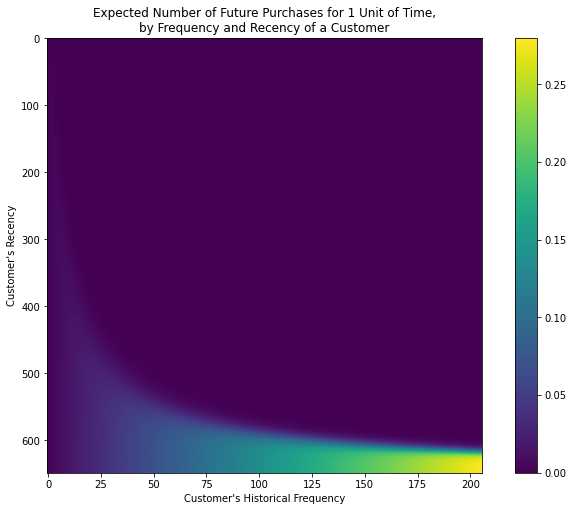

In [29]:
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(paretonbd_model(summary))

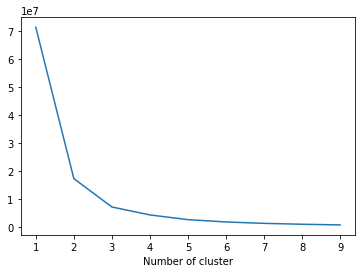

In [30]:
from sklearn.cluster import KMeans


MYSEED = 199
sse={}
t6_recency = t6[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(t6_recency)
    t6_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Recency Cluster

In [31]:
kmeans = KMeans(n_clusters=4,random_state=MYSEED)
kmeans.fit(t6[['recency']])
t6['RecencyCluster'] = kmeans.predict(t6[['recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

t6_cust = order_cluster('RecencyCluster', 'recency',t6,False)

t6_cust.groupby('RecencyCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,653.0,583.998469,42.093472,506.0,547.00,587.0,624.00,647.0
1,494.0,427.890688,49.069105,346.0,382.25,427.5,474.75,505.0
2,413.0,263.285714,50.493734,176.0,220.00,266.0,304.00,345.0
3,389.0,88.969152,49.701159,1.0,44.00,91.0,130.00,175.0


Frequency cluster

In [32]:
kmeans = KMeans(n_clusters=4,random_state=MYSEED)
kmeans.fit(t6[['frequency_btyd']])
t6['FrequencyCluster'] = kmeans.predict(t6[['frequency_btyd']])

#order the frequency cluster
t6_cust = order_cluster('FrequencyCluster', 'frequency_btyd',t6,True)

#see details of each cluster
t6_cust.groupby('FrequencyCluster')['frequency_btyd'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1547.0,4.356173,2.885789,1.0,2.00,4.0,6.00,11.0
1,352.0,18.264205,5.752846,12.0,14.00,16.5,22.00,34.0
2,42.0,51.261905,14.240203,35.0,41.00,44.0,60.75,83.0
3,8.0,147.000000,35.286582,105.0,111.75,157.0,163.75,205.0


Monetary Cluster

In [33]:
#apply clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4,random_state=MYSEED)
kmeans.fit(t6[['target_monetary']])
t6['RevenueCluster'] = kmeans.predict(t6[['target_monetary']])


#order the cluster numbers
t6_cust = order_cluster('RevenueCluster', 'target_monetary',t6,True)

#show details of the dataframe
t6_cust.groupby('RevenueCluster')['target_monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1916.0,4531.199525,5362.026219,30.95,1349.485,2759.89,5399.7600,39918.19
1,26.0,79906.008077,32022.881934,43515.05,55785.985,66855.02,108149.5175,147142.77
2,5.0,243483.248000,60359.554785,172132.87,195640.690,244784.25,291420.8100,313437.62
3,2.0,554794.780000,37041.449321,528602.52,541698.650,554794.78,567890.9100,580987.04


Overall score based on RFM

In [34]:
t6_cust['OverallScore'] = t6_cust['RecencyCluster'] + t6_cust['FrequencyCluster'] + t6_cust['RevenueCluster']
t6_cust.groupby('OverallScore')['recency','frequency_btyd','target_monetary'].mean()

,recency,frequency_btyd,target_monetary
OverallScore,,,
0,262.327411,3.474619,2341.824873
1,565.346505,7.057751,4461.122918
2,122.346341,4.895122,2966.897902
3,426.146497,7.388535,6039.409703
4,597.916058,20.485401,12913.294380
5,484.312500,42.750000,156164.135625
6,441.407407,18.592593,8400.639815
7,428.000000,18.000000,144458.370000


In [35]:
t6_cust['Segment'] = 'Low-Value'
t6_cust.loc[t6_cust['OverallScore']>3,'Segment'] = 'Mid-Value' 
t6_cust.loc[t6_cust['OverallScore']>5,'Segment'] = 'High-Value' 

In [36]:
t6_cust.head(10)

,customer_id,monetary_dnn,monetary_btyd,frequency_dnn,frequency_btyd,recency,T,time_between,avg_basket_value,avg_basket_size,...,has_returned,frequency_btyd_clipped,monetary_btyd_clipped,target_monetary_clipped,target_monetary,RecencyCluster,FrequencyCluster,RevenueCluster,OverallScore,Segment
0,12347,3402.39,558,6,5,275,313,45.83,567.07,349.83,...,0,6,558.1719999999999,4921.53,4921.53,0,0,0,0,Low-Value
1,12348,1709.40,495,4,3,190,347,47.50,427.35,624.25,...,0,4,495.74666666666667,2019.40,2019.40,0,0,0,0,Low-Value
2,12349,2671.14,801,3,2,182,498,60.67,890.38,331.00,...,0,3,801.31,4428.69,4428.69,0,0,0,0,Low-Value
3,12352,1905.61,352,6,5,130,301,21.67,317.60,73.67,...,0,6,352.37199999999996,2849.84,2849.84,2,0,0,2,Low-Value
4,12356,6313.38,1350,5,4,179,333,35.80,1262.68,682.20,...,0,5,1350.735,6371.73,6371.73,0,0,0,0,Low-Value
5,12358,3203.87,591,4,3,582,641,145.50,800.97,232.75,...,0,4,591.3466666666667,3887.07,3887.07,1,0,0,1,Low-Value
6,12359,6059.09,662,9,8,546,644,60.67,673.23,232.78,...,0,9,662.3,8873.39,8873.39,1,0,0,1,Low-Value
7,12360,3209.11,515,7,6,544,565,77.71,458.44,281.14,...,0,7,515.185,4252.89,4252.89,1,0,0,1,Low-Value
8,12362,1877.35,436,5,4,619,648,123.80,375.47,197.80,...,0,5,436.8375,5356.23,5356.23,1,0,0,1,Low-Value
9,12370,3577.28,753,5,4,395,578,79.00,715.46,444.80,...,0,5,753.5799999999999,4316.56,4316.56,3,0,0,3,Low-Value


In [37]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.6 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=a858062f2ccd0732c89c82f32065b6fa181186a297129ba16452e5eb51f9af44
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [38]:
t6_cust.groupby('Segment').customer_id.count()/t6_cust.customer_id.count()*100

Segment
High-Value     2.821960
Low-Value     82.298615
Mid-Value     14.879425
Name: customer_id, dtype: float64

In [39]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
t6_graph  = t6_cust.query("target_monetary < 50000 and frequency_btyd < 2000")

plot_data = [
    go.Scatter(
        x=t6_graph.query("Segment == 'Low-Value'")['frequency_btyd'],
        y=t6_graph.query("Segment == 'Low-Value'")['target_monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'Mid-Value'")['frequency_btyd'],
        y=t6_graph.query("Segment == 'Mid-Value'")['target_monetary'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'High-Value'")['frequency_btyd'],
        y=t6_graph.query("Segment == 'High-Value'")['monetary_btyd'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue Recency

t6_graph = t6_cust.query("target_monetary < 50000 and frequency_btyd < 2000")

plot_data = [
    go.Scatter(
        x=t6_graph.query("Segment == 'Low-Value'")['recency'],
        y=t6_graph.query("Segment == 'Low-Value'")['target_monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'Mid-Value'")['recency'],
        y=t6_graph.query("Segment == 'Mid-Value'")['target_monetary'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'High-Value'")['recency'],
        y=t6_graph.query("Segment == 'High-Value'")['target_monetary'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Revenue vs Frequency
t6_graph = t6_cust.query("target_monetary < 50000 and frequency_btyd < 2000")

plot_data = [
    go.Scatter(
        x=t6_graph.query("Segment == 'Low-Value'")['recency'],
        y=t6_graph.query("Segment == 'Low-Value'")['frequency_btyd'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'Mid-Value'")['recency'],
        y=t6_graph.query("Segment == 'Mid-Value'")['frequency_btyd'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'High-Value'")['recency'],
        y=t6_graph.query("Segment == 'High-Value'")['frequency_btyd'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [40]:
#remove outliers
t6_cust = t6_cust[t6_cust['target_monetary']<t6_cust['target_monetary'].quantile(0.99)]

In [41]:
t6_cust.head()

,customer_id,monetary_dnn,monetary_btyd,frequency_dnn,frequency_btyd,recency,T,time_between,avg_basket_value,avg_basket_size,...,has_returned,frequency_btyd_clipped,monetary_btyd_clipped,target_monetary_clipped,target_monetary,RecencyCluster,FrequencyCluster,RevenueCluster,OverallScore,Segment
0,12347,3402.39,558,6,5,275,313,45.83,567.07,349.83,...,0,6,558.1719999999999,4921.53,4921.53,0,0,0,0,Low-Value
1,12348,1709.40,495,4,3,190,347,47.50,427.35,624.25,...,0,4,495.74666666666667,2019.40,2019.40,0,0,0,0,Low-Value
2,12349,2671.14,801,3,2,182,498,60.67,890.38,331.00,...,0,3,801.31,4428.69,4428.69,0,0,0,0,Low-Value
3,12352,1905.61,352,6,5,130,301,21.67,317.60,73.67,...,0,6,352.37199999999996,2849.84,2849.84,2,0,0,2,Low-Value
4,12356,6313.38,1350,5,4,179,333,35.80,1262.68,682.20,...,0,5,1350.735,6371.73,6371.73,0,0,0,0,Low-Value


In [42]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
t6_cust['LTVCluster'] = kmeans.fit_predict(t6_cust[['target_monetary']])

t6_cust.head()

,customer_id,monetary_dnn,monetary_btyd,frequency_dnn,frequency_btyd,recency,T,time_between,avg_basket_value,avg_basket_size,...,frequency_btyd_clipped,monetary_btyd_clipped,target_monetary_clipped,target_monetary,RecencyCluster,FrequencyCluster,RevenueCluster,OverallScore,Segment,LTVCluster
0,12347,3402.39,558,6,5,275,313,45.83,567.07,349.83,...,6,558.1719999999999,4921.53,4921.53,0,0,0,0,Low-Value,0
1,12348,1709.40,495,4,3,190,347,47.50,427.35,624.25,...,4,495.74666666666667,2019.40,2019.40,0,0,0,0,Low-Value,0
2,12349,2671.14,801,3,2,182,498,60.67,890.38,331.00,...,3,801.31,4428.69,4428.69,0,0,0,0,Low-Value,0
3,12352,1905.61,352,6,5,130,301,21.67,317.60,73.67,...,6,352.37199999999996,2849.84,2849.84,2,0,0,2,Low-Value,0
4,12356,6313.38,1350,5,4,179,333,35.80,1262.68,682.20,...,5,1350.735,6371.73,6371.73,0,0,0,0,Low-Value,0


In [43]:
#order cluster number based on LTV
t6_cust = order_cluster('LTVCluster', 'target_monetary',t6_cust,True)

#creatinga new cluster dataframe
tx_cluster = t6_cust.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['target_monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1642.0,2782.042923,1931.338900,30.95,1213.1375,2285.410,3938.1275,8189.56
1,254.0,13552.865433,4931.907769,8202.98,9731.1950,11976.505,16257.3750,27347.04
2,33.0,41757.789091,11475.502479,28882.44,32275.9500,37642.480,50174.7800,65164.79


In [44]:
tx_cluster.head()

,customer_id,monetary_dnn,monetary_btyd,frequency_dnn,frequency_btyd,recency,T,time_between,avg_basket_value,avg_basket_size,...,frequency_btyd_clipped,monetary_btyd_clipped,target_monetary_clipped,target_monetary,RecencyCluster,FrequencyCluster,RevenueCluster,OverallScore,Segment,LTVCluster
0,12347,3402.39,558,6,5,275,313,45.83,567.07,349.83,...,6,558.1719999999999,4921.53,4921.53,0,0,0,0,Low-Value,0
1,12348,1709.40,495,4,3,190,347,47.50,427.35,624.25,...,4,495.74666666666667,2019.40,2019.40,0,0,0,0,Low-Value,0
2,12349,2671.14,801,3,2,182,498,60.67,890.38,331.00,...,3,801.31,4428.69,4428.69,0,0,0,0,Low-Value,0
3,12352,1905.61,352,6,5,130,301,21.67,317.60,73.67,...,6,352.37199999999996,2849.84,2849.84,2,0,0,2,Low-Value,0
4,12356,6313.38,1350,5,4,179,333,35.80,1262.68,682.20,...,5,1350.735,6371.73,6371.73,0,0,0,0,Low-Value,0


In [45]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster) #There is only one categorical variable segment
tx_class.head()

TypeError: ignored

In [ ]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

In [ ]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','target_monetary'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)
y_pred2 = ltv_xgb_model.predict(X_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print('RMSE: ', mean_squared_error(y_train, y_pred2)**(1/2))
print('SMAPE', smape(y_train, y_pred2))
print('R2: ', r2_score(y_train, y_pred2))

In [ ]:
print(classification_report(y_test, y_pred))